In [76]:
import os
import datetime
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize,LinearSegmentedColormap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn.exceptions
from sklearn.utils import class_weight
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

from tensorflow.python.client import device_lib
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D, ZeroPadding2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
finish_sound = "afplay /Users/mehmet/Documents/vs-code/winsquare.mp3"

In [77]:
[x.name for x in device_lib.list_local_devices()]
# !conda install -y -n ml ipykernel=6.23.2 numpy==1.24.0 matplotlib=3.7.1 pandas=2.0.2 seaborn=0.12.1 scikit-learn=1.3.2 tensorflow=2.11.1
# !jupyter nbconvert --to html skin-cancer-cnn.ipynb

['/device:CPU:0']

In [78]:
# removing duplicate images from same lesion

df=pd.read_csv('dataverse_files/HAM10000_metadata.csv')
# if your image names have no extension
df['image_id'] = df['image_id'].astype(str) + '.jpg'

df=df.drop(['image_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
df = df[df['dx'] != 'vasc']
df = df[df['dx'] != 'df']
labels = df['dx'].unique() # 7 labels
labels = list(labels)
labels.sort()
print(labels)
df.drop_duplicates( subset=['lesion_id'], keep=False, inplace=True)
# how many images are there for each labels
lesion_counts = []
df_lesion = df['dx'].sort_values()
for label in labels:
    lesion_counts += [len(df[df['dx'] == label])]
    #print("There are " + str(len(df[df['dx'] == label])) + " images belong to " + label + " label")
print(lesion_counts)

['akiec', 'bcc', 'bkl', 'mel', 'nv']
[151, 175, 440, 230, 4415]


In [79]:
# Same for test set

df_test=pd.read_csv('dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv')
# if your image names have no extension
df_test['image_id'] = df_test['image_id'].astype(str) + '.jpg'

df_test=df_test.drop(['image_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
labels_test = df_test['dx'].unique() # 7 labels_test
labels_test = list(labels_test)
labels_test.sort()
print(labels_test)
df_test.drop_duplicates( subset=['lesion_id'], keep=False, inplace=True)
# how many images are there for each labels_test
lesion_counts_test = []
df_test_lesion = df_test['dx'].sort_values()
for label in labels_test:
    lesion_counts_test += [len(df_test[df_test['dx'] == label])]
    #print("There are " + str(len(df_test[df_test['dx'] == label])) + " images belong to " + label + " label")
print(lesion_counts_test)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
[21, 56, 132, 37, 60, 665, 26]


In [80]:
df=pd.read_csv('dataverse_files/HAM10000_metadata.csv')
# if your image names have no extension
df['image_id'] = df['image_id'].astype(str) + '.jpg'

df=df.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
labels = df['dx'].unique() # 7 labels
labels = list(labels)
labels.sort()
print(labels)
# how many images are there for each labels
image_counts = []
df_image = df['dx'].sort_values()
for label in labels:
    image_counts += [len(df[df['dx'] == label])]
    #print("There are " + str(len(df[df['dx'] == label])) + " images belong to " + label + " label")
print(image_counts)


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
[327, 514, 1099, 115, 1113, 6705, 142]


In [81]:
# Same for test 
df_test=pd.read_csv('dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv')
# if your image names have no extension
df_test['image_id'] = df_test['image_id'].astype(str) + '.jpg'

df_test=df_test.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
labels_test = df_test['dx'].unique() # 7 labels_test
labels_test = list(labels_test)
labels_test.sort()
print(labels_test)
# how many images are there for each labels_test
image_counts_test = []
df_test_image = df_test['dx'].sort_values()
for label in labels_test:
    image_counts_test += [len(df_test[df_test['dx'] == label])]
    #print("There are " + str(len(df_test[df_test['dx'] == label])) + " images belong to " + label + " label")
print(image_counts_test)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
[43, 93, 217, 44, 171, 909, 35]


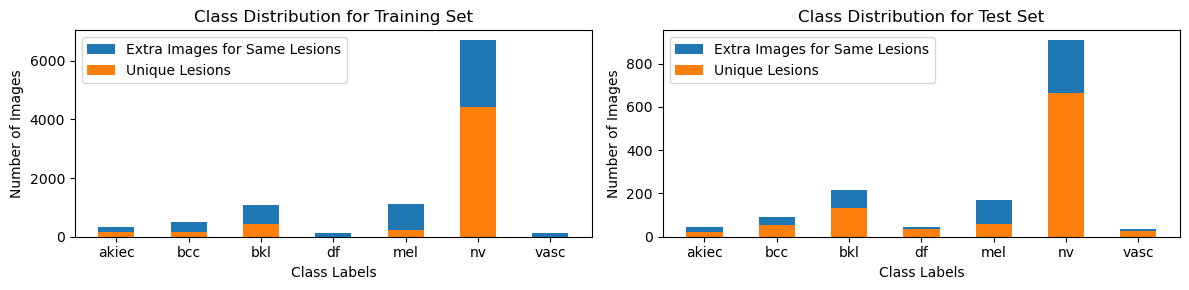

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
bins = np.linspace(0 - .25, 6 + .25, 14)

# Plotting class distribution for training set

ax1.hist(df_image.values, bins=bins)
ax1.hist(df_lesion.values, bins=bins)
ax1.set_title("Class Distribution for Training Set")
ax1.set_xlabel('Class Labels')
ax1.set_ylabel('Number of Images')
ax1.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

# Plotting class distribution  for test set
ax2.hist(df_test_image.values, bins=bins)
ax2.hist(df_test_lesion.values, bins=bins)
ax2.set_title("Class Distribution for Test Set")
ax2.set_xlabel('Class Labels')
ax2.set_ylabel('Number of Images')
ax2.legend(['Extra Images for Same Lesions', 'Unique Lesions'])

plt.tight_layout()
#plt.savefig('class_distribution.png')
plt.show()


In [83]:
'''
random.seed(42)
np.random.seed(42)
np.random.RandomState(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
'''

"\nrandom.seed(42)\nnp.random.seed(42)\nnp.random.RandomState(42)\ntf.random.set_seed(42)\nos.environ['TF_DETERMINISTIC_OPS'] = '1'\n"

In [84]:
# np.random.seed(42)
# grouped = df.groupby('dx')
# for label in labels:
#     drop_indices = []
#     if grouped.get_group(label).shape[0] > 1000:
#         remove_n = grouped.get_group(label).shape[0] - 1000 # number of images in the smallest class
#         drop_indices = np.random.choice(grouped.get_group(label).index, remove_n, replace=False)
#         df = df.drop(drop_indices) # drop extra images from original dataset

In [85]:
# 'ISIC_0035068.jpg' is missing in the dataset, lets remove it from test set
df_test = df_test[df_test['image_id'] != 'ISIC_0035068.jpg']

print(labels,'\n')

df.sort_values(by=['image_id'], inplace=True)
df.reset_index(inplace=True, drop=True)
df_test.sort_values(by=['image_id'], inplace=True)
df_test.reset_index(inplace=True, drop=True)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 



In [86]:
train_df, val_df=train_test_split(df, train_size=0.9, shuffle=True, random_state=123, stratify=df['dx']) 
test_df = df_test.copy().sample(frac=1, random_state=123).reset_index(drop=True) # shuffle test set
for label in labels:
    list1 = len(train_df[train_df['dx'] == label]), len(val_df[val_df['dx'] == label]), len(test_df[test_df['dx'] == label])
    space = ' '
    print(label,(5-len(label))*space ,list1)
    
train_df.shape, val_df.shape, test_df.shape

akiec  (294, 33, 43)
bcc    (463, 51, 93)
bkl    (989, 110, 217)
df     (103, 12, 44)
mel    (1002, 111, 171)
nv     (6034, 671, 908)
vasc   (128, 14, 35)


((9013, 2), (1002, 2), (1511, 2))

In [87]:
# Train and test data paths
train_path = "dataverse_files/HAM10000_images_pca"
test_path = "dataverse_files/ISIC2018_Task3_Test_Images"

# Read the data
df = pd.read_csv('dataverse_files/HAM10000_metadata.csv')
df_test = pd.read_csv('dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv')
df = df[df['dx'] != 'vasc']
df = df[df['dx'] != 'df']
df_test = df_test[df_test['dx'] != 'vasc']
df_test = df_test[df_test['dx'] != 'df']
labels = df['dx'].sort_values().unique()

# Add .jpg to image_id column
df['image_id'] = df['image_id'].astype(str) + '.jpg'
df_test['image_id'] = df_test['image_id'].astype(str) + '.jpg'

# Drop unused columns
df=df.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
df_test=df_test.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)

# 'ISIC_0035068.jpg' is missing in the test set file, lets remove it from test set dataframe
df_test = df_test[df_test['image_id'] != 'ISIC_0035068.jpg']

print(labels,'\n')

df.sort_values(by=['image_id'], inplace=True)
df.reset_index(inplace=True, drop=True)
df_test.sort_values(by=['image_id'], inplace=True)
df_test.reset_index(inplace=True, drop=True)

train_df, val_df=train_test_split(df, train_size=0.9, shuffle=True, random_state=123, stratify=df['dx'])
train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)
test_df = df_test.copy().sample(frac=1, random_state=123).reset_index(drop=True) # shuffle test set


#To use augmented data
x = '_3'
train_path = 'dataverse_files/HAM10000_images_pca_augmented'+x
train_df = pd.read_csv('dataverse_files/HAM10000_metadata_augmented'+x+'_train.csv')
val_df = pd.read_csv('dataverse_files/HAM10000_metadata_augmented'+x+'_val.csv')

for label in labels:
    list1 = len(train_df[train_df['dx'] == label]), len(val_df[val_df['dx'] == label]), len(test_df[test_df['dx'] == label])
    space = ' '
    print(label,(5-len(label))*space ,list1)
    
train_df.shape, val_df.shape, test_df.shape

['akiec' 'bcc' 'bkl' 'mel' 'nv'] 

akiec  (1000, 70, 43)
bcc    (1000, 70, 93)
bkl    (1011, 80, 217)
mel    (1067, 70, 171)
nv     (1100, 80, 908)


((5178, 8), (370, 8), (1432, 2))

In [88]:
target_size = (71, 71)

In [89]:
# Keras ImageDataGenerator
rescale=1./255
color_mode = 'rgb'
batch_size  = 64
# 600 x 450

train_datagen = ImageDataGenerator(rescale=rescale)
train_set = train_datagen.flow_from_dataframe(train_df,
                                              directory=train_path,
                                              x_col="image_id",
                                              y_col="dx",
                                              color_mode=color_mode,
                                              target_size=target_size,
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False
                                              )
val_datagen = ImageDataGenerator(rescale=rescale)
val_set = val_datagen.flow_from_dataframe(val_df,
                                          directory=train_path,
                                          x_col="image_id",
                                          y_col="dx",
                                          color_mode=color_mode,
                                          target_size=target_size,
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False
                                          )
test_datagen = ImageDataGenerator(rescale=rescale)
test_set = test_datagen.flow_from_dataframe(test_df,
                                            directory=test_path,
                                            x_col="image_id",
                                            y_col="dx",
                                            color_mode=color_mode,
                                            target_size=target_size,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False
                                            )

Found 5178 validated image filenames belonging to 5 classes.
Found 370 validated image filenames belonging to 5 classes.
Found 1432 validated image filenames belonging to 5 classes.


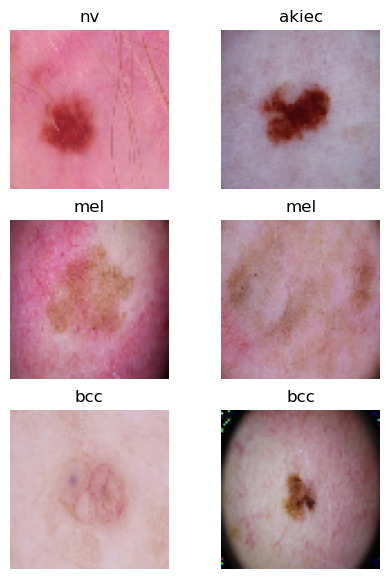

In [111]:
# random images from train set
dict1 = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'mel', 4: 'nv'}
# get label name from dict1
plt.figure(figsize=(5,7))
# random images from train set
np.random.seed(33)
for i in range(6):
    random_select = np.random.randint(0, train_set.samples//(batch_size-2))
    plt.subplot(3,2,i+1)
    plt.title(dict1[train_set.labels[random_select]])
    plt.imshow(train_set[random_select][0][0])
    plt.axis('off')
plt.show()